In [1]:
import json
import os
import subprocess
from IPython.display import clear_output

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda


# Generate metrics

In [2]:
from functions_utils_pomo import get_metrics     

In [3]:
cur_path = os.getcwd()
metrics = get_metrics(cur_path)
os.chdir('./Reward_weights')
for m in metrics:

    dic_tarif_sent_disp = {'v_required': 0,
                    'v_sent': 0,
                    'v_sent_full':0,
                    'v_degraded':0,
                    'cancelled':0, #cancel departure
                    'function_not_found':0,
                    'v1_not_sent_from_s1':0,
                    'v3_not_sent_from_s3':0,
                    'v_not_found_in_last_station':0,
                    'ff_required':0,
                    'ff_sent':0,
                    'rupture_ff':0,       
                    'z1_VSAV_sent': 0,
                    'z1_FPT_sent': 0,
                    'z1_EPA_sent': 0,
                     'VSAV_needed':0,
                     'FPT_needed':0,
                     'EPA_needed':0,
                     'VSAV_disp':0,
                     'FPT_disp':0,
                     'EPA_disp':0,
                    'skill_lvl':0
                    } 

    dic_tarif_sent_disp[m] = -100

    if m == 'v_degraded':
        
        dic_tarif_sent_disp['v_sent_full'] = 10


    with open(f"rw_"+ m +"_r100_cf3.json", "w") as f:
        json.dump(dic_tarif_sent_disp, f)

os.chdir("../")

In [4]:
os.chdir('./Reward_weights')
metric = "v1_not_sent_from_1st_station"
with open(f"rw_{metric}_r100_cf3.json", "r") as f:
    d = json.load(f)
os.chdir("../")
d

{'v_sent': 0,
 'v_sent_full': 0,
 'v_degraded': 0,
 'cancelled': 0,
 'function_not_found': 0,
 'v1_not_sent_from_1st_station': -100,
 'v_not_found_in_last_station': 0,
 'z1_sent': 0,
 'skill_lvl': 0}

# Agent params

In [10]:
cmd = ["python3", "-u", "agent_pomo_run.py"]

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

line_count = 0
for line in process.stdout:
    line_count += 1
    #if line_count % 100 == 0:
        #clear_output(wait=True)

    print(line.strip())

Nombre d'agents = 2. On démarre...
[PARENT] Agent élu: v_degraded
max_train_steps 995
lr decay: 1 decay_update: 100 PER 1
max_train_steps 995
lr decay: 1 decay_update: 100 PER 1
Dueling_QNetwork(
(model): Sequential(
(0): Linear(in_features=3280, out_features=1024, bias=True)
(1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(2): ReLU()
(3): Linear(in_features=1024, out_features=1024, bias=True)
(4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(5): ReLU()
(6): Linear(in_features=1024, out_features=1024, bias=True)
(7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(8): ReLU()
(9): Linear(in_features=1024, out_features=1024, bias=True)
(10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(11): ReLU()
(12): Linear(in_features=1024, out_features=1024, bias=True)
(13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [15]:
# Chemin vers ton fichier
path = "./SVG_model/shared_state_dqn.pt"  # adapte si besoin

# Charger le contenu
data = torch.load(path, map_location=device,weights_only=False)  # map_location='cpu' si t'as pas besoin du GPU

# Afficher le type d'objet
print("Type :", type(data))

# S’il s’agit d’un dict :
if isinstance(data, dict):
    for key in data:
        print(f"{key}: {type(data[key])}")
        try:
            print(f" - valeur (résumé) : {data[key]}")
        except:
            print(f" - valeur non affichable")
print(data.shape)
print(data)

Type : <class 'numpy.ndarray'>
(82, 40)
[[1.         1.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.125      0.125      0.125      ... 0.08796296 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


[[[1.00000e+00 0.00000e+00]
  [2.00000e+00 0.00000e+00]
  [3.00000e+00 0.00000e+00]
  ...
  [2.53773e+05 0.00000e+00]
  [2.53774e+05 0.00000e+00]
  [2.53775e+05 0.00000e+00]]]


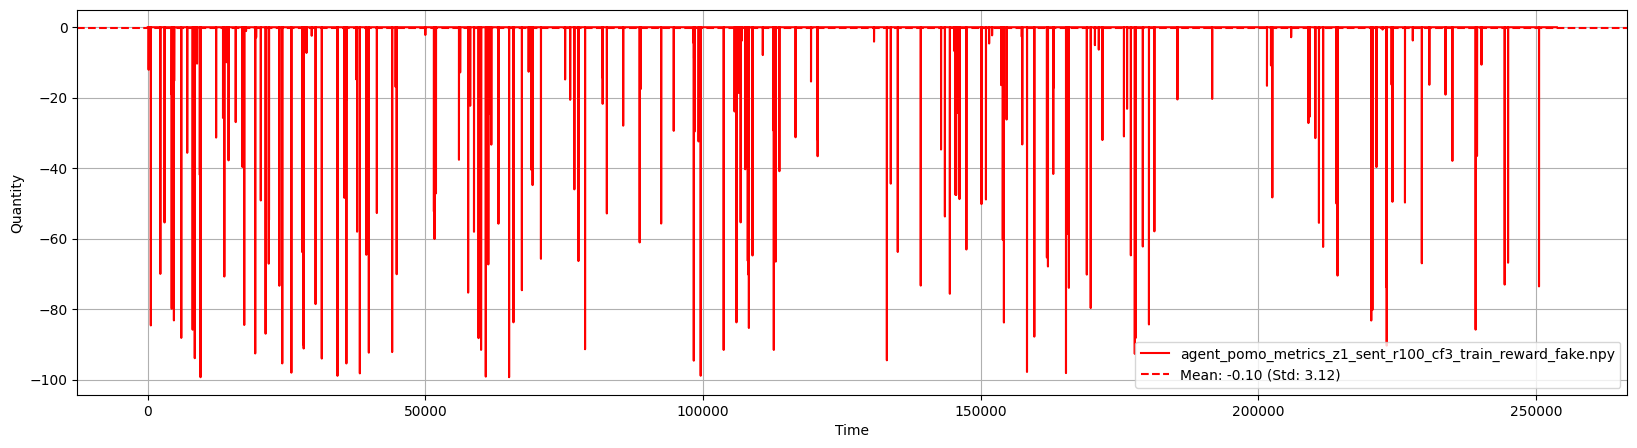

Fin du script. Tout s’est bien déroulé.


In [ ]:
import numpy as np

def load_agent_rewards(metrics, num_agents=2):
    """Charge les récompenses de tous les agents depuis les fichiers .npy"""
    all_rewards = []
    for i in range(num_agents):
        file_path = f"Plots/agent_pomo_metrics_{metrics[i]}_r100_cf3_train_reward_fake.npy"
        if os.path.exists(file_path):
            rewards = np.load(file_path)
            all_rewards.append(rewards)
    return np.array(all_rewards)

def compute_pomo_loss(all_rewards):
    """Calcule la loss POMO avec baseline partagée comme dans le papier"""
    rewards_tensor = torch.tensor(all_rewards, dtype=torch.float32)
    baseline = rewards_tensor.mean(dim=0, keepdim=True)
    advantages = rewards_tensor - baseline
    loss = -torch.mean(advantages * torch.log(rewards_tensor + 1e-10))
    return loss

metrics = ['z1_sent', 'v_not_found_in_last_station']
num_agents = len(metrics)
all_rewards = load_agent_rewards(metrics, num_agents)
loss = compute_pomo_loss(all_rewards)

print(all_rewards)

%run plot_evo.py agent_pomo_metrics_z1_sent_r100_cf3_train_reward_fake.npy --interpolation 100000
